In [1]:
!pip install torch torchvision matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
import os
import torch
from torchvision import transforms
from PIL import Image

# 定義圖片目錄和變換
image_dir = '/content/drive/MyDrive/Colab Notebooks/image'  # 替換為你的圖片資料夾路徑
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
])

# 加載圖片
images = []
for file_name in os.listdir(image_dir):
    if file_name.endswith('img_.png'):
        image_path = os.path.join(image_dir, file_name)
        image = Image.open(image_path).convert('RGB')
        image = transform(image)
        images.append(image)

# 創建數據集和數據加載器
dataset = torch.utils.data.TensorDataset(torch.stack(images))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)


In [20]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleDDPM(nn.Module):
    def __init__(self, image_size, in_channels, out_channels, hidden_dim):
        super(SimpleDDPM, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(hidden_dim, out_channels, kernel_size=3, padding=1)

    def forward(self, x, t):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# 定義模型
model = SimpleDDPM(image_size=64, in_channels=3, out_channels=3, hidden_dim=64).cuda()

In [21]:
import torch.optim as optim
from tqdm import tqdm

optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 500  # 根據需要設置

def diffusion_loss(model, x, t):
    noise = torch.randn_like(x)
    x_noisy = x + noise * t.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
    predicted_noise = model(x_noisy, t)
    return F.mse_loss(predicted_noise, noise)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for x in tqdm(dataloader):
        x = x[0].cuda()
        t = torch.rand(x.size(0)).cuda()
        loss = diffusion_loss(model, x, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader)}')

100%|██████████| 222/222 [00:00<00:00, 338.95it/s]


Epoch 1/500, Loss: 0.27039479756274737


100%|██████████| 222/222 [00:00<00:00, 455.43it/s]


Epoch 2/500, Loss: 0.14851205044233048


100%|██████████| 222/222 [00:00<00:00, 447.79it/s]


Epoch 3/500, Loss: 0.12794740771589516


100%|██████████| 222/222 [00:00<00:00, 457.90it/s]


Epoch 4/500, Loss: 0.12051569089830459


100%|██████████| 222/222 [00:00<00:00, 450.49it/s]


Epoch 5/500, Loss: 0.11674498053485746


100%|██████████| 222/222 [00:00<00:00, 452.78it/s]


Epoch 6/500, Loss: 0.11239433523502436


100%|██████████| 222/222 [00:00<00:00, 441.86it/s]


Epoch 7/500, Loss: 0.10196859426460825


100%|██████████| 222/222 [00:00<00:00, 459.45it/s]


Epoch 8/500, Loss: 0.10085497430718697


100%|██████████| 222/222 [00:00<00:00, 458.60it/s]


Epoch 9/500, Loss: 0.1059562777345245


100%|██████████| 222/222 [00:00<00:00, 447.42it/s]


Epoch 10/500, Loss: 0.09832806111657405


100%|██████████| 222/222 [00:00<00:00, 451.73it/s]


Epoch 11/500, Loss: 0.10818262438516359


100%|██████████| 222/222 [00:00<00:00, 457.06it/s]


Epoch 12/500, Loss: 0.10893672409358325


100%|██████████| 222/222 [00:00<00:00, 451.01it/s]


Epoch 13/500, Loss: 0.10273255612533372


100%|██████████| 222/222 [00:00<00:00, 450.22it/s]


Epoch 14/500, Loss: 0.10425742910251962


100%|██████████| 222/222 [00:00<00:00, 457.65it/s]


Epoch 15/500, Loss: 0.09752941703809812


100%|██████████| 222/222 [00:00<00:00, 442.37it/s]


Epoch 16/500, Loss: 0.10134566509844484


100%|██████████| 222/222 [00:00<00:00, 453.95it/s]


Epoch 17/500, Loss: 0.10165638684689461


100%|██████████| 222/222 [00:00<00:00, 449.83it/s]


Epoch 18/500, Loss: 0.1081880166421871


100%|██████████| 222/222 [00:00<00:00, 453.96it/s]


Epoch 19/500, Loss: 0.08886657265929489


100%|██████████| 222/222 [00:00<00:00, 448.48it/s]


Epoch 20/500, Loss: 0.08608672653769588


100%|██████████| 222/222 [00:00<00:00, 426.75it/s]


Epoch 21/500, Loss: 0.10101965507744132


100%|██████████| 222/222 [00:00<00:00, 401.11it/s]


Epoch 22/500, Loss: 0.09603043902363326


100%|██████████| 222/222 [00:00<00:00, 391.74it/s]


Epoch 23/500, Loss: 0.09795975339439539


100%|██████████| 222/222 [00:00<00:00, 410.12it/s]


Epoch 24/500, Loss: 0.09065429797513527


100%|██████████| 222/222 [00:00<00:00, 407.38it/s]


Epoch 25/500, Loss: 0.08729813375451544


100%|██████████| 222/222 [00:00<00:00, 378.21it/s]


Epoch 26/500, Loss: 0.09560196625219809


100%|██████████| 222/222 [00:00<00:00, 427.27it/s]


Epoch 27/500, Loss: 0.09466597649293977


100%|██████████| 222/222 [00:00<00:00, 446.16it/s]


Epoch 28/500, Loss: 0.10502854518189624


100%|██████████| 222/222 [00:00<00:00, 440.32it/s]


Epoch 29/500, Loss: 0.09447615083541956


100%|██████████| 222/222 [00:00<00:00, 446.26it/s]


Epoch 30/500, Loss: 0.09177298867353448


100%|██████████| 222/222 [00:00<00:00, 448.52it/s]


Epoch 31/500, Loss: 0.09074227060484993


100%|██████████| 222/222 [00:00<00:00, 452.74it/s]


Epoch 32/500, Loss: 0.08839752541871758


100%|██████████| 222/222 [00:00<00:00, 431.03it/s]


Epoch 33/500, Loss: 0.08989458022689498


100%|██████████| 222/222 [00:00<00:00, 456.86it/s]


Epoch 34/500, Loss: 0.08980870736880345


100%|██████████| 222/222 [00:00<00:00, 449.69it/s]


Epoch 35/500, Loss: 0.08620108348560764


100%|██████████| 222/222 [00:00<00:00, 445.99it/s]


Epoch 36/500, Loss: 0.0886897603469389


100%|██████████| 222/222 [00:00<00:00, 444.22it/s]


Epoch 37/500, Loss: 0.08763600679466853


100%|██████████| 222/222 [00:00<00:00, 452.68it/s]


Epoch 38/500, Loss: 0.09292286075651646


100%|██████████| 222/222 [00:00<00:00, 451.19it/s]


Epoch 39/500, Loss: 0.10091196911761889


100%|██████████| 222/222 [00:00<00:00, 449.03it/s]


Epoch 40/500, Loss: 0.09810549884967439


100%|██████████| 222/222 [00:00<00:00, 441.03it/s]


Epoch 41/500, Loss: 0.08513977638705894


100%|██████████| 222/222 [00:00<00:00, 448.06it/s]


Epoch 42/500, Loss: 0.0851227504847286


100%|██████████| 222/222 [00:00<00:00, 442.95it/s]


Epoch 43/500, Loss: 0.0901686815662427


100%|██████████| 222/222 [00:00<00:00, 444.14it/s]


Epoch 44/500, Loss: 0.08724961473463892


100%|██████████| 222/222 [00:00<00:00, 442.92it/s]


Epoch 45/500, Loss: 0.09278557677795221


100%|██████████| 222/222 [00:00<00:00, 447.68it/s]


Epoch 46/500, Loss: 0.08519921572627248


100%|██████████| 222/222 [00:00<00:00, 378.20it/s]


Epoch 47/500, Loss: 0.08900536187328734


100%|██████████| 222/222 [00:00<00:00, 400.83it/s]


Epoch 48/500, Loss: 0.09332027026192025


100%|██████████| 222/222 [00:00<00:00, 380.16it/s]


Epoch 49/500, Loss: 0.08866955949043906


100%|██████████| 222/222 [00:00<00:00, 401.97it/s]


Epoch 50/500, Loss: 0.08358037183145145


100%|██████████| 222/222 [00:00<00:00, 371.31it/s]


Epoch 51/500, Loss: 0.08554297499358654


100%|██████████| 222/222 [00:00<00:00, 412.35it/s]


Epoch 52/500, Loss: 0.08733575465577142


100%|██████████| 222/222 [00:00<00:00, 454.45it/s]


Epoch 53/500, Loss: 0.0861095685411144


100%|██████████| 222/222 [00:00<00:00, 450.98it/s]


Epoch 54/500, Loss: 0.08429633310853361


100%|██████████| 222/222 [00:00<00:00, 450.28it/s]


Epoch 55/500, Loss: 0.0848180388209519


100%|██████████| 222/222 [00:00<00:00, 451.24it/s]


Epoch 56/500, Loss: 0.08926685142691608


100%|██████████| 222/222 [00:00<00:00, 448.16it/s]


Epoch 57/500, Loss: 0.08791748951147269


100%|██████████| 222/222 [00:00<00:00, 453.89it/s]


Epoch 58/500, Loss: 0.09009447690468651


100%|██████████| 222/222 [00:00<00:00, 447.44it/s]


Epoch 59/500, Loss: 0.08724732891664849


100%|██████████| 222/222 [00:00<00:00, 452.82it/s]


Epoch 60/500, Loss: 0.07763305061438062


100%|██████████| 222/222 [00:00<00:00, 452.00it/s]


Epoch 61/500, Loss: 0.09148611767670593


100%|██████████| 222/222 [00:00<00:00, 448.28it/s]


Epoch 62/500, Loss: 0.08490560500807054


100%|██████████| 222/222 [00:00<00:00, 451.97it/s]


Epoch 63/500, Loss: 0.08394193129093798


100%|██████████| 222/222 [00:00<00:00, 454.14it/s]


Epoch 64/500, Loss: 0.08268835674132313


100%|██████████| 222/222 [00:00<00:00, 452.18it/s]


Epoch 65/500, Loss: 0.0855153762810939


100%|██████████| 222/222 [00:00<00:00, 449.91it/s]


Epoch 66/500, Loss: 0.07907630860604145


100%|██████████| 222/222 [00:00<00:00, 446.43it/s]


Epoch 67/500, Loss: 0.09140028794472282


100%|██████████| 222/222 [00:00<00:00, 448.69it/s]


Epoch 68/500, Loss: 0.08327969514370502


100%|██████████| 222/222 [00:00<00:00, 443.26it/s]


Epoch 69/500, Loss: 0.09309101091311858


100%|██████████| 222/222 [00:00<00:00, 446.81it/s]


Epoch 70/500, Loss: 0.08411089841041479


100%|██████████| 222/222 [00:00<00:00, 444.54it/s]


Epoch 71/500, Loss: 0.0905375586537359


100%|██████████| 222/222 [00:00<00:00, 401.17it/s]


Epoch 72/500, Loss: 0.08286219873876723


100%|██████████| 222/222 [00:00<00:00, 407.18it/s]


Epoch 73/500, Loss: 0.08595688896136242


100%|██████████| 222/222 [00:00<00:00, 384.47it/s]


Epoch 74/500, Loss: 0.09384218551352755


100%|██████████| 222/222 [00:00<00:00, 414.41it/s]


Epoch 75/500, Loss: 0.07886457424778659


100%|██████████| 222/222 [00:00<00:00, 378.42it/s]


Epoch 76/500, Loss: 0.09234244240498221


100%|██████████| 222/222 [00:00<00:00, 383.62it/s]


Epoch 77/500, Loss: 0.08236017838321827


100%|██████████| 222/222 [00:00<00:00, 448.03it/s]


Epoch 78/500, Loss: 0.0836908883742384


100%|██████████| 222/222 [00:00<00:00, 446.93it/s]


Epoch 79/500, Loss: 0.08434399880200356


100%|██████████| 222/222 [00:00<00:00, 448.93it/s]


Epoch 80/500, Loss: 0.0777865114479183


100%|██████████| 222/222 [00:00<00:00, 448.97it/s]


Epoch 81/500, Loss: 0.08377273822085815


100%|██████████| 222/222 [00:00<00:00, 450.81it/s]


Epoch 82/500, Loss: 0.08493729308247566


100%|██████████| 222/222 [00:00<00:00, 443.60it/s]


Epoch 83/500, Loss: 0.07969423920453132


100%|██████████| 222/222 [00:00<00:00, 453.12it/s]


Epoch 84/500, Loss: 0.08674432478241019


100%|██████████| 222/222 [00:00<00:00, 451.51it/s]


Epoch 85/500, Loss: 0.07641918228955956


100%|██████████| 222/222 [00:00<00:00, 455.64it/s]


Epoch 86/500, Loss: 0.09176007226982096


100%|██████████| 222/222 [00:00<00:00, 445.73it/s]


Epoch 87/500, Loss: 0.08594549448976109


100%|██████████| 222/222 [00:00<00:00, 451.73it/s]


Epoch 88/500, Loss: 0.08300610314551238


100%|██████████| 222/222 [00:00<00:00, 441.11it/s]


Epoch 89/500, Loss: 0.08648957595699006


100%|██████████| 222/222 [00:00<00:00, 446.92it/s]


Epoch 90/500, Loss: 0.0857213953056851


100%|██████████| 222/222 [00:00<00:00, 434.65it/s]


Epoch 91/500, Loss: 0.07873766727510605


100%|██████████| 222/222 [00:00<00:00, 439.60it/s]


Epoch 92/500, Loss: 0.08685229763992734


100%|██████████| 222/222 [00:00<00:00, 449.64it/s]


Epoch 93/500, Loss: 0.09515995286438647


100%|██████████| 222/222 [00:00<00:00, 448.02it/s]


Epoch 94/500, Loss: 0.09024012023331346


100%|██████████| 222/222 [00:00<00:00, 442.86it/s]


Epoch 95/500, Loss: 0.0794472503937311


100%|██████████| 222/222 [00:00<00:00, 448.57it/s]


Epoch 96/500, Loss: 0.081348316374797


100%|██████████| 222/222 [00:00<00:00, 420.03it/s]


Epoch 97/500, Loss: 0.09022579090418043


100%|██████████| 222/222 [00:00<00:00, 410.16it/s]


Epoch 98/500, Loss: 0.086636951780534


100%|██████████| 222/222 [00:00<00:00, 393.06it/s]


Epoch 99/500, Loss: 0.07793971850863986


100%|██████████| 222/222 [00:00<00:00, 412.29it/s]


Epoch 100/500, Loss: 0.07898475223027908


100%|██████████| 222/222 [00:00<00:00, 391.36it/s]


Epoch 101/500, Loss: 0.08487333367402489


100%|██████████| 222/222 [00:00<00:00, 389.72it/s]


Epoch 102/500, Loss: 0.08620529519477943


100%|██████████| 222/222 [00:00<00:00, 418.55it/s]


Epoch 103/500, Loss: 0.08696723686581528


100%|██████████| 222/222 [00:00<00:00, 442.15it/s]


Epoch 104/500, Loss: 0.08020071779285465


100%|██████████| 222/222 [00:00<00:00, 435.11it/s]


Epoch 105/500, Loss: 0.08488611887032921


100%|██████████| 222/222 [00:00<00:00, 440.74it/s]


Epoch 106/500, Loss: 0.08404524031153938


100%|██████████| 222/222 [00:00<00:00, 439.02it/s]


Epoch 107/500, Loss: 0.08724926126835582


100%|██████████| 222/222 [00:00<00:00, 445.58it/s]


Epoch 108/500, Loss: 0.08051478562389945


100%|██████████| 222/222 [00:00<00:00, 446.60it/s]


Epoch 109/500, Loss: 0.08650737416905326


100%|██████████| 222/222 [00:00<00:00, 445.85it/s]


Epoch 110/500, Loss: 0.08125845091165723


100%|██████████| 222/222 [00:00<00:00, 449.54it/s]


Epoch 111/500, Loss: 0.08855116685332211


100%|██████████| 222/222 [00:00<00:00, 452.76it/s]


Epoch 112/500, Loss: 0.08051058803559155


100%|██████████| 222/222 [00:00<00:00, 439.22it/s]


Epoch 113/500, Loss: 0.08734107155117903


100%|██████████| 222/222 [00:00<00:00, 447.38it/s]


Epoch 114/500, Loss: 0.07987291713220042


100%|██████████| 222/222 [00:00<00:00, 437.04it/s]


Epoch 115/500, Loss: 0.08387198178349314


100%|██████████| 222/222 [00:00<00:00, 450.02it/s]


Epoch 116/500, Loss: 0.0832128979869791


100%|██████████| 222/222 [00:00<00:00, 442.57it/s]


Epoch 117/500, Loss: 0.08783457169795895


100%|██████████| 222/222 [00:00<00:00, 445.01it/s]


Epoch 118/500, Loss: 0.09063547134802148


100%|██████████| 222/222 [00:00<00:00, 439.88it/s]


Epoch 119/500, Loss: 0.0863283223195656


100%|██████████| 222/222 [00:00<00:00, 446.95it/s]


Epoch 120/500, Loss: 0.07724426931760332


100%|██████████| 222/222 [00:00<00:00, 439.27it/s]


Epoch 121/500, Loss: 0.08004299182075637


100%|██████████| 222/222 [00:00<00:00, 435.90it/s]


Epoch 122/500, Loss: 0.08993933665322827


100%|██████████| 222/222 [00:00<00:00, 398.21it/s]


Epoch 123/500, Loss: 0.07955856941774622


100%|██████████| 222/222 [00:00<00:00, 390.57it/s]


Epoch 124/500, Loss: 0.08451280202548783


100%|██████████| 222/222 [00:00<00:00, 409.25it/s]


Epoch 125/500, Loss: 0.08717174642627035


100%|██████████| 222/222 [00:00<00:00, 409.12it/s]


Epoch 126/500, Loss: 0.08111299819371721


100%|██████████| 222/222 [00:00<00:00, 380.02it/s]


Epoch 127/500, Loss: 0.08199171367864888


100%|██████████| 222/222 [00:00<00:00, 409.64it/s]


Epoch 128/500, Loss: 0.09195411966291366


100%|██████████| 222/222 [00:00<00:00, 445.38it/s]


Epoch 129/500, Loss: 0.08153647794346283


100%|██████████| 222/222 [00:00<00:00, 444.19it/s]


Epoch 130/500, Loss: 0.08031907842100204


100%|██████████| 222/222 [00:00<00:00, 439.12it/s]


Epoch 131/500, Loss: 0.0799232762776785


100%|██████████| 222/222 [00:00<00:00, 442.09it/s]


Epoch 132/500, Loss: 0.0794556364584882


100%|██████████| 222/222 [00:00<00:00, 446.44it/s]


Epoch 133/500, Loss: 0.08212572478831888


100%|██████████| 222/222 [00:00<00:00, 446.76it/s]


Epoch 134/500, Loss: 0.07936694818708273


100%|██████████| 222/222 [00:00<00:00, 447.11it/s]


Epoch 135/500, Loss: 0.09129316292636029


100%|██████████| 222/222 [00:00<00:00, 441.88it/s]


Epoch 136/500, Loss: 0.08144920425036468


100%|██████████| 222/222 [00:00<00:00, 447.17it/s]


Epoch 137/500, Loss: 0.08222108320878432


100%|██████████| 222/222 [00:00<00:00, 439.77it/s]


Epoch 138/500, Loss: 0.08216528566805897


100%|██████████| 222/222 [00:00<00:00, 446.75it/s]


Epoch 139/500, Loss: 0.08436293846315092


100%|██████████| 222/222 [00:00<00:00, 439.40it/s]


Epoch 140/500, Loss: 0.08233289075763645


100%|██████████| 222/222 [00:00<00:00, 445.56it/s]


Epoch 141/500, Loss: 0.07763339914717116


100%|██████████| 222/222 [00:00<00:00, 442.49it/s]


Epoch 142/500, Loss: 0.07694297336746712


100%|██████████| 222/222 [00:00<00:00, 443.57it/s]


Epoch 143/500, Loss: 0.08153898767321496


100%|██████████| 222/222 [00:00<00:00, 441.41it/s]


Epoch 144/500, Loss: 0.0880958173121955


100%|██████████| 222/222 [00:00<00:00, 441.64it/s]


Epoch 145/500, Loss: 0.07815475395234588


100%|██████████| 222/222 [00:00<00:00, 439.80it/s]


Epoch 146/500, Loss: 0.07844615422256358


100%|██████████| 222/222 [00:00<00:00, 440.95it/s]


Epoch 147/500, Loss: 0.08477957149011058


100%|██████████| 222/222 [00:00<00:00, 390.01it/s]


Epoch 148/500, Loss: 0.07328749866736634


100%|██████████| 222/222 [00:00<00:00, 396.78it/s]


Epoch 149/500, Loss: 0.08216424098422935


100%|██████████| 222/222 [00:00<00:00, 388.90it/s]


Epoch 150/500, Loss: 0.07917594837511445


100%|██████████| 222/222 [00:00<00:00, 395.85it/s]


Epoch 151/500, Loss: 0.07891013741761714


100%|██████████| 222/222 [00:00<00:00, 369.92it/s]


Epoch 152/500, Loss: 0.08184319428327652


100%|██████████| 222/222 [00:00<00:00, 398.78it/s]


Epoch 153/500, Loss: 0.08391348636700763


100%|██████████| 222/222 [00:00<00:00, 446.63it/s]


Epoch 154/500, Loss: 0.08268719632178545


100%|██████████| 222/222 [00:00<00:00, 446.45it/s]


Epoch 155/500, Loss: 0.08501969448181691


100%|██████████| 222/222 [00:00<00:00, 444.39it/s]


Epoch 156/500, Loss: 0.08316814768556002


100%|██████████| 222/222 [00:00<00:00, 447.96it/s]


Epoch 157/500, Loss: 0.08038245750641501


100%|██████████| 222/222 [00:00<00:00, 445.69it/s]


Epoch 158/500, Loss: 0.08508874540561223


100%|██████████| 222/222 [00:00<00:00, 447.36it/s]


Epoch 159/500, Loss: 0.07339860432621864


100%|██████████| 222/222 [00:00<00:00, 445.23it/s]


Epoch 160/500, Loss: 0.0783195723653645


100%|██████████| 222/222 [00:00<00:00, 443.14it/s]


Epoch 161/500, Loss: 0.08508192361877845


100%|██████████| 222/222 [00:00<00:00, 431.65it/s]


Epoch 162/500, Loss: 0.0853414808878222


100%|██████████| 222/222 [00:00<00:00, 441.80it/s]


Epoch 163/500, Loss: 0.08061909614349003


100%|██████████| 222/222 [00:00<00:00, 441.98it/s]


Epoch 164/500, Loss: 0.08003533591289778


100%|██████████| 222/222 [00:00<00:00, 440.17it/s]


Epoch 165/500, Loss: 0.07402069241580395


100%|██████████| 222/222 [00:00<00:00, 421.06it/s]


Epoch 166/500, Loss: 0.07996293130490156


100%|██████████| 222/222 [00:00<00:00, 441.91it/s]


Epoch 167/500, Loss: 0.08340334784877193


100%|██████████| 222/222 [00:00<00:00, 440.47it/s]


Epoch 168/500, Loss: 0.08874425500933383


100%|██████████| 222/222 [00:00<00:00, 448.69it/s]


Epoch 169/500, Loss: 0.08703963795827853


100%|██████████| 222/222 [00:00<00:00, 440.37it/s]


Epoch 170/500, Loss: 0.08145317642504836


100%|██████████| 222/222 [00:00<00:00, 448.13it/s]


Epoch 171/500, Loss: 0.07925988641475235


100%|██████████| 222/222 [00:00<00:00, 440.41it/s]


Epoch 172/500, Loss: 0.08540985352351321


100%|██████████| 222/222 [00:00<00:00, 396.78it/s]


Epoch 173/500, Loss: 0.07595292282466953


100%|██████████| 222/222 [00:00<00:00, 394.70it/s]


Epoch 174/500, Loss: 0.08357628778898502


100%|██████████| 222/222 [00:00<00:00, 388.55it/s]


Epoch 175/500, Loss: 0.0828338790986989


100%|██████████| 222/222 [00:00<00:00, 391.33it/s]


Epoch 176/500, Loss: 0.07748449730544209


100%|██████████| 222/222 [00:00<00:00, 364.46it/s]


Epoch 177/500, Loss: 0.08242087024222086


100%|██████████| 222/222 [00:00<00:00, 385.23it/s]


Epoch 178/500, Loss: 0.07818006252584693


100%|██████████| 222/222 [00:00<00:00, 439.42it/s]


Epoch 179/500, Loss: 0.083812324053331


100%|██████████| 222/222 [00:00<00:00, 448.48it/s]


Epoch 180/500, Loss: 0.0754807965645382


100%|██████████| 222/222 [00:00<00:00, 439.37it/s]


Epoch 181/500, Loss: 0.08251175724037059


100%|██████████| 222/222 [00:00<00:00, 446.11it/s]


Epoch 182/500, Loss: 0.08734527253755578


100%|██████████| 222/222 [00:00<00:00, 441.90it/s]


Epoch 183/500, Loss: 0.08066408728828302


100%|██████████| 222/222 [00:00<00:00, 445.60it/s]


Epoch 184/500, Loss: 0.07434336445084563


100%|██████████| 222/222 [00:00<00:00, 438.69it/s]


Epoch 185/500, Loss: 0.0793673427658038


100%|██████████| 222/222 [00:00<00:00, 449.68it/s]


Epoch 186/500, Loss: 0.07624695173187836


100%|██████████| 222/222 [00:00<00:00, 428.47it/s]


Epoch 187/500, Loss: 0.08348698017967714


100%|██████████| 222/222 [00:00<00:00, 442.04it/s]


Epoch 188/500, Loss: 0.0792578924531201


100%|██████████| 222/222 [00:00<00:00, 437.07it/s]


Epoch 189/500, Loss: 0.08066427195864218


100%|██████████| 222/222 [00:00<00:00, 443.75it/s]


Epoch 190/500, Loss: 0.08001046322353252


100%|██████████| 222/222 [00:00<00:00, 435.31it/s]


Epoch 191/500, Loss: 0.0753447292959905


100%|██████████| 222/222 [00:00<00:00, 446.55it/s]


Epoch 192/500, Loss: 0.08632208180387278


100%|██████████| 222/222 [00:00<00:00, 440.76it/s]


Epoch 193/500, Loss: 0.08128640669825915


100%|██████████| 222/222 [00:00<00:00, 442.21it/s]


Epoch 194/500, Loss: 0.08058164726842094


100%|██████████| 222/222 [00:00<00:00, 438.89it/s]


Epoch 195/500, Loss: 0.07677375624241593


100%|██████████| 222/222 [00:00<00:00, 447.50it/s]


Epoch 196/500, Loss: 0.07578606359861992


100%|██████████| 222/222 [00:00<00:00, 443.39it/s]


Epoch 197/500, Loss: 0.08389595183669715


100%|██████████| 222/222 [00:00<00:00, 398.78it/s]


Epoch 198/500, Loss: 0.07921922664988686


100%|██████████| 222/222 [00:00<00:00, 396.64it/s]


Epoch 199/500, Loss: 0.0777601035194354


100%|██████████| 222/222 [00:00<00:00, 387.58it/s]


Epoch 200/500, Loss: 0.08211307328295063


100%|██████████| 222/222 [00:00<00:00, 400.24it/s]


Epoch 201/500, Loss: 0.08348877732180529


100%|██████████| 222/222 [00:00<00:00, 374.28it/s]


Epoch 202/500, Loss: 0.08154318154462285


100%|██████████| 222/222 [00:00<00:00, 389.07it/s]


Epoch 203/500, Loss: 0.08624321882621394


100%|██████████| 222/222 [00:00<00:00, 445.14it/s]


Epoch 204/500, Loss: 0.07705834751260711


100%|██████████| 222/222 [00:00<00:00, 438.34it/s]


Epoch 205/500, Loss: 0.07436782478245797


100%|██████████| 222/222 [00:00<00:00, 449.76it/s]


Epoch 206/500, Loss: 0.07910577291706661


100%|██████████| 222/222 [00:00<00:00, 434.10it/s]


Epoch 207/500, Loss: 0.07943970345900403


100%|██████████| 222/222 [00:00<00:00, 428.87it/s]


Epoch 208/500, Loss: 0.07968154479120229


100%|██████████| 222/222 [00:00<00:00, 439.32it/s]


Epoch 209/500, Loss: 0.08043547952128155


100%|██████████| 222/222 [00:00<00:00, 443.00it/s]


Epoch 210/500, Loss: 0.08128259763927073


100%|██████████| 222/222 [00:00<00:00, 438.20it/s]


Epoch 211/500, Loss: 0.07769783064387403


100%|██████████| 222/222 [00:00<00:00, 439.58it/s]


Epoch 212/500, Loss: 0.0851422017356297


100%|██████████| 222/222 [00:00<00:00, 431.32it/s]


Epoch 213/500, Loss: 0.08533873152289842


100%|██████████| 222/222 [00:00<00:00, 446.32it/s]


Epoch 214/500, Loss: 0.08009114367300058


100%|██████████| 222/222 [00:00<00:00, 447.99it/s]


Epoch 215/500, Loss: 0.07581614800267392


100%|██████████| 222/222 [00:00<00:00, 452.10it/s]


Epoch 216/500, Loss: 0.07894460977734746


100%|██████████| 222/222 [00:00<00:00, 445.92it/s]


Epoch 217/500, Loss: 0.07833115592061936


100%|██████████| 222/222 [00:00<00:00, 446.72it/s]


Epoch 218/500, Loss: 0.07798729712764423


100%|██████████| 222/222 [00:00<00:00, 432.74it/s]


Epoch 219/500, Loss: 0.0754239993119562


100%|██████████| 222/222 [00:00<00:00, 429.66it/s]


Epoch 220/500, Loss: 0.07505047566316149


100%|██████████| 222/222 [00:00<00:00, 439.07it/s]


Epoch 221/500, Loss: 0.08567605299354943


100%|██████████| 222/222 [00:00<00:00, 438.46it/s]


Epoch 222/500, Loss: 0.0783310693327908


100%|██████████| 222/222 [00:00<00:00, 377.43it/s]


Epoch 223/500, Loss: 0.0836233612955422


100%|██████████| 222/222 [00:00<00:00, 395.77it/s]


Epoch 224/500, Loss: 0.07822403756414985


100%|██████████| 222/222 [00:00<00:00, 389.83it/s]


Epoch 225/500, Loss: 0.084582478647028


100%|██████████| 222/222 [00:00<00:00, 394.74it/s]


Epoch 226/500, Loss: 0.0813811838979254


100%|██████████| 222/222 [00:00<00:00, 378.20it/s]


Epoch 227/500, Loss: 0.08505861236302702


100%|██████████| 222/222 [00:00<00:00, 383.73it/s]


Epoch 228/500, Loss: 0.07143159349960787


100%|██████████| 222/222 [00:00<00:00, 447.54it/s]


Epoch 229/500, Loss: 0.07855032597509054


100%|██████████| 222/222 [00:00<00:00, 440.27it/s]


Epoch 230/500, Loss: 0.0767545589824786


100%|██████████| 222/222 [00:00<00:00, 445.92it/s]


Epoch 231/500, Loss: 0.07927037407182627


100%|██████████| 222/222 [00:00<00:00, 432.72it/s]


Epoch 232/500, Loss: 0.07189968386077666


100%|██████████| 222/222 [00:00<00:00, 438.86it/s]


Epoch 233/500, Loss: 0.08395376125233131


100%|██████████| 222/222 [00:00<00:00, 437.63it/s]


Epoch 234/500, Loss: 0.07093694626546658


100%|██████████| 222/222 [00:00<00:00, 443.23it/s]


Epoch 235/500, Loss: 0.0776777591992606


100%|██████████| 222/222 [00:00<00:00, 425.86it/s]


Epoch 236/500, Loss: 0.06887226555127281


100%|██████████| 222/222 [00:00<00:00, 442.73it/s]


Epoch 237/500, Loss: 0.08112653832345663


100%|██████████| 222/222 [00:00<00:00, 443.26it/s]


Epoch 238/500, Loss: 0.0832552071828563


100%|██████████| 222/222 [00:00<00:00, 447.93it/s]


Epoch 239/500, Loss: 0.07418272505841546


100%|██████████| 222/222 [00:00<00:00, 438.25it/s]


Epoch 240/500, Loss: 0.0785799402374405


100%|██████████| 222/222 [00:00<00:00, 443.05it/s]


Epoch 241/500, Loss: 0.07915805488287865


100%|██████████| 222/222 [00:00<00:00, 442.34it/s]


Epoch 242/500, Loss: 0.08261074727350795


100%|██████████| 222/222 [00:00<00:00, 447.93it/s]


Epoch 243/500, Loss: 0.0746305367598931


100%|██████████| 222/222 [00:00<00:00, 445.30it/s]


Epoch 244/500, Loss: 0.07309370311732227


100%|██████████| 222/222 [00:00<00:00, 444.10it/s]


Epoch 245/500, Loss: 0.07522646911643646


100%|██████████| 222/222 [00:00<00:00, 442.14it/s]


Epoch 246/500, Loss: 0.07636909225435408


100%|██████████| 222/222 [00:00<00:00, 445.70it/s]


Epoch 247/500, Loss: 0.07902872126952216


100%|██████████| 222/222 [00:00<00:00, 392.31it/s]


Epoch 248/500, Loss: 0.07362363131733628


100%|██████████| 222/222 [00:00<00:00, 404.69it/s]


Epoch 249/500, Loss: 0.0843789900846041


100%|██████████| 222/222 [00:00<00:00, 373.71it/s]


Epoch 250/500, Loss: 0.07922281400376074


100%|██████████| 222/222 [00:00<00:00, 417.31it/s]


Epoch 251/500, Loss: 0.07828736525901535


100%|██████████| 222/222 [00:00<00:00, 386.92it/s]


Epoch 252/500, Loss: 0.07437998555634204


100%|██████████| 222/222 [00:00<00:00, 367.55it/s]


Epoch 253/500, Loss: 0.07906328906045035


100%|██████████| 222/222 [00:00<00:00, 429.57it/s]


Epoch 254/500, Loss: 0.08122998875406412


100%|██████████| 222/222 [00:00<00:00, 444.43it/s]


Epoch 255/500, Loss: 0.08114575493980099


100%|██████████| 222/222 [00:00<00:00, 437.14it/s]


Epoch 256/500, Loss: 0.08238746080681816


100%|██████████| 222/222 [00:00<00:00, 435.12it/s]


Epoch 257/500, Loss: 0.0793389853610246


100%|██████████| 222/222 [00:00<00:00, 435.60it/s]


Epoch 258/500, Loss: 0.07936822570994631


100%|██████████| 222/222 [00:00<00:00, 435.81it/s]


Epoch 259/500, Loss: 0.08550798874516208


100%|██████████| 222/222 [00:00<00:00, 436.74it/s]


Epoch 260/500, Loss: 0.07761592189739416


100%|██████████| 222/222 [00:00<00:00, 434.26it/s]


Epoch 261/500, Loss: 0.07844809944498109


100%|██████████| 222/222 [00:00<00:00, 426.46it/s]


Epoch 262/500, Loss: 0.07760430271695326


100%|██████████| 222/222 [00:00<00:00, 433.33it/s]


Epoch 263/500, Loss: 0.08212269405490374


100%|██████████| 222/222 [00:00<00:00, 447.32it/s]


Epoch 264/500, Loss: 0.07983960682811501


100%|██████████| 222/222 [00:00<00:00, 436.38it/s]


Epoch 265/500, Loss: 0.076754161500716


100%|██████████| 222/222 [00:00<00:00, 442.44it/s]


Epoch 266/500, Loss: 0.0749591690328744


100%|██████████| 222/222 [00:00<00:00, 440.05it/s]


Epoch 267/500, Loss: 0.07273812261452009


100%|██████████| 222/222 [00:00<00:00, 443.46it/s]


Epoch 268/500, Loss: 0.07584233773318497


100%|██████████| 222/222 [00:00<00:00, 441.38it/s]


Epoch 269/500, Loss: 0.08084603349535584


100%|██████████| 222/222 [00:00<00:00, 444.92it/s]


Epoch 270/500, Loss: 0.07575239972756789


100%|██████████| 222/222 [00:00<00:00, 443.20it/s]


Epoch 271/500, Loss: 0.0764967800025736


100%|██████████| 222/222 [00:00<00:00, 444.51it/s]


Epoch 272/500, Loss: 0.08085742322644135


100%|██████████| 222/222 [00:00<00:00, 406.64it/s]


Epoch 273/500, Loss: 0.07572650082979922


100%|██████████| 222/222 [00:00<00:00, 394.48it/s]


Epoch 274/500, Loss: 0.07866015045291132


100%|██████████| 222/222 [00:00<00:00, 381.39it/s]


Epoch 275/500, Loss: 0.0804315114326708


100%|██████████| 222/222 [00:00<00:00, 406.67it/s]


Epoch 276/500, Loss: 0.08212451566312765


100%|██████████| 222/222 [00:00<00:00, 397.39it/s]


Epoch 277/500, Loss: 0.0778589690909595


100%|██████████| 222/222 [00:00<00:00, 361.73it/s]


Epoch 278/500, Loss: 0.0733597309051736


100%|██████████| 222/222 [00:00<00:00, 406.03it/s]


Epoch 279/500, Loss: 0.0820318241645624


100%|██████████| 222/222 [00:00<00:00, 428.76it/s]


Epoch 280/500, Loss: 0.08288115309131844


100%|██████████| 222/222 [00:00<00:00, 437.90it/s]


Epoch 281/500, Loss: 0.07987971697841678


100%|██████████| 222/222 [00:00<00:00, 437.19it/s]


Epoch 282/500, Loss: 0.07700334996119276


100%|██████████| 222/222 [00:00<00:00, 429.20it/s]


Epoch 283/500, Loss: 0.08078332309116114


100%|██████████| 222/222 [00:00<00:00, 440.30it/s]


Epoch 284/500, Loss: 0.07860394939780235


100%|██████████| 222/222 [00:00<00:00, 441.20it/s]


Epoch 285/500, Loss: 0.08408186582193987


100%|██████████| 222/222 [00:00<00:00, 448.56it/s]


Epoch 286/500, Loss: 0.08110785680646831


100%|██████████| 222/222 [00:00<00:00, 441.99it/s]


Epoch 287/500, Loss: 0.08078982925193536


100%|██████████| 222/222 [00:00<00:00, 436.74it/s]


Epoch 288/500, Loss: 0.08242502367241425


100%|██████████| 222/222 [00:00<00:00, 434.06it/s]


Epoch 289/500, Loss: 0.07171513258504707


100%|██████████| 222/222 [00:00<00:00, 443.77it/s]


Epoch 290/500, Loss: 0.08624503501430825


100%|██████████| 222/222 [00:00<00:00, 440.46it/s]


Epoch 291/500, Loss: 0.0772728411698932


100%|██████████| 222/222 [00:00<00:00, 446.48it/s]


Epoch 292/500, Loss: 0.07429783432199075


100%|██████████| 222/222 [00:00<00:00, 439.41it/s]


Epoch 293/500, Loss: 0.07902180687062912


100%|██████████| 222/222 [00:00<00:00, 445.27it/s]


Epoch 294/500, Loss: 0.07350524330327103


100%|██████████| 222/222 [00:00<00:00, 440.51it/s]


Epoch 295/500, Loss: 0.07292677356383286


100%|██████████| 222/222 [00:00<00:00, 443.35it/s]


Epoch 296/500, Loss: 0.07699333683394634


100%|██████████| 222/222 [00:00<00:00, 441.03it/s]


Epoch 297/500, Loss: 0.07880804355482797


100%|██████████| 222/222 [00:00<00:00, 435.99it/s]


Epoch 298/500, Loss: 0.0800332394134891


100%|██████████| 222/222 [00:00<00:00, 380.85it/s]


Epoch 299/500, Loss: 0.08294259576412204


100%|██████████| 222/222 [00:00<00:00, 379.64it/s]


Epoch 300/500, Loss: 0.07568836336334546


100%|██████████| 222/222 [00:00<00:00, 391.83it/s]


Epoch 301/500, Loss: 0.0677080679903025


100%|██████████| 222/222 [00:00<00:00, 391.14it/s]


Epoch 302/500, Loss: 0.08130726818968584


100%|██████████| 222/222 [00:00<00:00, 384.54it/s]


Epoch 303/500, Loss: 0.0771836687953354


100%|██████████| 222/222 [00:00<00:00, 387.15it/s]


Epoch 304/500, Loss: 0.07258175391502478


100%|██████████| 222/222 [00:00<00:00, 441.57it/s]


Epoch 305/500, Loss: 0.08944964272951758


100%|██████████| 222/222 [00:00<00:00, 441.04it/s]


Epoch 306/500, Loss: 0.08529320936482232


100%|██████████| 222/222 [00:00<00:00, 442.75it/s]


Epoch 307/500, Loss: 0.07862839904857112


100%|██████████| 222/222 [00:00<00:00, 433.43it/s]


Epoch 308/500, Loss: 0.08246695963447695


100%|██████████| 222/222 [00:00<00:00, 452.25it/s]


Epoch 309/500, Loss: 0.07486899571308682


100%|██████████| 222/222 [00:00<00:00, 451.77it/s]


Epoch 310/500, Loss: 0.07695567519781557


100%|██████████| 222/222 [00:00<00:00, 449.01it/s]


Epoch 311/500, Loss: 0.0835377369915043


100%|██████████| 222/222 [00:00<00:00, 441.90it/s]


Epoch 312/500, Loss: 0.08169045111349037


100%|██████████| 222/222 [00:00<00:00, 438.70it/s]


Epoch 313/500, Loss: 0.07180523995712802


100%|██████████| 222/222 [00:00<00:00, 441.83it/s]


Epoch 314/500, Loss: 0.07469672186149133


100%|██████████| 222/222 [00:00<00:00, 439.66it/s]


Epoch 315/500, Loss: 0.0823201424282816


100%|██████████| 222/222 [00:00<00:00, 442.72it/s]


Epoch 316/500, Loss: 0.08123332261200156


100%|██████████| 222/222 [00:00<00:00, 441.57it/s]


Epoch 317/500, Loss: 0.07752839201507536


100%|██████████| 222/222 [00:00<00:00, 439.44it/s]


Epoch 318/500, Loss: 0.0762045490261805


100%|██████████| 222/222 [00:00<00:00, 445.08it/s]


Epoch 319/500, Loss: 0.078975999207647


100%|██████████| 222/222 [00:00<00:00, 443.78it/s]


Epoch 320/500, Loss: 0.08440641045301885


100%|██████████| 222/222 [00:00<00:00, 443.80it/s]


Epoch 321/500, Loss: 0.07374541045309187


100%|██████████| 222/222 [00:00<00:00, 450.00it/s]


Epoch 322/500, Loss: 0.07966833476077866


100%|██████████| 222/222 [00:00<00:00, 439.04it/s]


Epoch 323/500, Loss: 0.07763561942018904


100%|██████████| 222/222 [00:00<00:00, 392.01it/s]


Epoch 324/500, Loss: 0.08048640513742292


100%|██████████| 222/222 [00:00<00:00, 390.06it/s]


Epoch 325/500, Loss: 0.07338095529357323


100%|██████████| 222/222 [00:00<00:00, 382.92it/s]


Epoch 326/500, Loss: 0.08561555261782429


100%|██████████| 222/222 [00:00<00:00, 421.16it/s]


Epoch 327/500, Loss: 0.08562781268244123


100%|██████████| 222/222 [00:00<00:00, 377.89it/s]


Epoch 328/500, Loss: 0.07793271652347333


100%|██████████| 222/222 [00:00<00:00, 361.76it/s]


Epoch 329/500, Loss: 0.08493213201998859


100%|██████████| 222/222 [00:00<00:00, 439.91it/s]


Epoch 330/500, Loss: 0.07860436704144017


100%|██████████| 222/222 [00:00<00:00, 440.22it/s]


Epoch 331/500, Loss: 0.07597645167429168


100%|██████████| 222/222 [00:00<00:00, 444.72it/s]


Epoch 332/500, Loss: 0.0809145718141719


100%|██████████| 222/222 [00:00<00:00, 440.11it/s]


Epoch 333/500, Loss: 0.08281397646678998


100%|██████████| 222/222 [00:00<00:00, 442.79it/s]


Epoch 334/500, Loss: 0.07208794097810446


100%|██████████| 222/222 [00:00<00:00, 433.59it/s]


Epoch 335/500, Loss: 0.07657310859140781


100%|██████████| 222/222 [00:00<00:00, 444.48it/s]


Epoch 336/500, Loss: 0.07610638991736614


100%|██████████| 222/222 [00:00<00:00, 430.67it/s]


Epoch 337/500, Loss: 0.07648856373218534


100%|██████████| 222/222 [00:00<00:00, 431.95it/s]


Epoch 338/500, Loss: 0.08028305905896264


100%|██████████| 222/222 [00:00<00:00, 441.77it/s]


Epoch 339/500, Loss: 0.08287981225530038


100%|██████████| 222/222 [00:00<00:00, 446.13it/s]


Epoch 340/500, Loss: 0.07944305236073765


100%|██████████| 222/222 [00:00<00:00, 439.29it/s]


Epoch 341/500, Loss: 0.0847054082766041


100%|██████████| 222/222 [00:00<00:00, 447.65it/s]


Epoch 342/500, Loss: 0.08167462141529934


100%|██████████| 222/222 [00:00<00:00, 436.14it/s]


Epoch 343/500, Loss: 0.0799583984488571


100%|██████████| 222/222 [00:00<00:00, 443.99it/s]


Epoch 344/500, Loss: 0.07371515266362343


100%|██████████| 222/222 [00:00<00:00, 432.99it/s]


Epoch 345/500, Loss: 0.07361296068474248


100%|██████████| 222/222 [00:00<00:00, 438.69it/s]


Epoch 346/500, Loss: 0.07995271994019146


100%|██████████| 222/222 [00:00<00:00, 442.19it/s]


Epoch 347/500, Loss: 0.07214822220775458


100%|██████████| 222/222 [00:00<00:00, 440.84it/s]


Epoch 348/500, Loss: 0.07519434735615242


100%|██████████| 222/222 [00:00<00:00, 397.52it/s]


Epoch 349/500, Loss: 0.0769816644087031


100%|██████████| 222/222 [00:00<00:00, 405.78it/s]


Epoch 350/500, Loss: 0.07630223777514321


100%|██████████| 222/222 [00:00<00:00, 388.57it/s]


Epoch 351/500, Loss: 0.07787322140558883


100%|██████████| 222/222 [00:00<00:00, 404.38it/s]


Epoch 352/500, Loss: 0.08078772510057902


100%|██████████| 222/222 [00:00<00:00, 384.50it/s]


Epoch 353/500, Loss: 0.07789903540197793


100%|██████████| 222/222 [00:00<00:00, 374.15it/s]


Epoch 354/500, Loss: 0.07977346720190735


100%|██████████| 222/222 [00:00<00:00, 410.54it/s]


Epoch 355/500, Loss: 0.07954511590100624


100%|██████████| 222/222 [00:00<00:00, 444.85it/s]


Epoch 356/500, Loss: 0.08275156975765754


100%|██████████| 222/222 [00:00<00:00, 436.04it/s]


Epoch 357/500, Loss: 0.07686705662457792


100%|██████████| 222/222 [00:00<00:00, 440.31it/s]


Epoch 358/500, Loss: 0.07440433343285108


100%|██████████| 222/222 [00:00<00:00, 443.06it/s]


Epoch 359/500, Loss: 0.07909380053044171


100%|██████████| 222/222 [00:00<00:00, 444.39it/s]


Epoch 360/500, Loss: 0.07611500189077479


100%|██████████| 222/222 [00:00<00:00, 443.79it/s]


Epoch 361/500, Loss: 0.07740301614509779


100%|██████████| 222/222 [00:00<00:00, 447.78it/s]


Epoch 362/500, Loss: 0.0740458972684972


100%|██████████| 222/222 [00:00<00:00, 440.60it/s]


Epoch 363/500, Loss: 0.07372992571342636


100%|██████████| 222/222 [00:00<00:00, 442.04it/s]


Epoch 364/500, Loss: 0.07921391312737723


100%|██████████| 222/222 [00:00<00:00, 445.77it/s]


Epoch 365/500, Loss: 0.07216999156249536


100%|██████████| 222/222 [00:00<00:00, 449.35it/s]


Epoch 366/500, Loss: 0.0713662221809631


100%|██████████| 222/222 [00:00<00:00, 437.45it/s]


Epoch 367/500, Loss: 0.07445094824206454


100%|██████████| 222/222 [00:00<00:00, 445.97it/s]


Epoch 368/500, Loss: 0.07761371713802889


100%|██████████| 222/222 [00:00<00:00, 446.14it/s]


Epoch 369/500, Loss: 0.08203566910883596


100%|██████████| 222/222 [00:00<00:00, 447.22it/s]


Epoch 370/500, Loss: 0.08252529452580053


100%|██████████| 222/222 [00:00<00:00, 442.78it/s]


Epoch 371/500, Loss: 0.07716491512182327


100%|██████████| 222/222 [00:00<00:00, 443.78it/s]


Epoch 372/500, Loss: 0.07483786289991291


100%|██████████| 222/222 [00:00<00:00, 433.06it/s]


Epoch 373/500, Loss: 0.0762853990099183


100%|██████████| 222/222 [00:00<00:00, 427.00it/s]


Epoch 374/500, Loss: 0.08184088919278201


100%|██████████| 222/222 [00:00<00:00, 383.51it/s]


Epoch 375/500, Loss: 0.08339877879700146


100%|██████████| 222/222 [00:00<00:00, 373.02it/s]


Epoch 376/500, Loss: 0.0743737862789416


100%|██████████| 222/222 [00:00<00:00, 372.00it/s]


Epoch 377/500, Loss: 0.07731348113366612


100%|██████████| 222/222 [00:00<00:00, 402.59it/s]


Epoch 378/500, Loss: 0.08263084210186929


100%|██████████| 222/222 [00:00<00:00, 374.92it/s]


Epoch 379/500, Loss: 0.07230577863719281


100%|██████████| 222/222 [00:00<00:00, 369.27it/s]


Epoch 380/500, Loss: 0.07874075434095151


100%|██████████| 222/222 [00:00<00:00, 442.10it/s]


Epoch 381/500, Loss: 0.08015032307253228


100%|██████████| 222/222 [00:00<00:00, 438.07it/s]


Epoch 382/500, Loss: 0.0822054621436306


100%|██████████| 222/222 [00:00<00:00, 437.61it/s]


Epoch 383/500, Loss: 0.0690643526949324


100%|██████████| 222/222 [00:00<00:00, 423.75it/s]


Epoch 384/500, Loss: 0.07479711767151817


100%|██████████| 222/222 [00:00<00:00, 442.04it/s]


Epoch 385/500, Loss: 0.07909281170918597


100%|██████████| 222/222 [00:00<00:00, 437.44it/s]


Epoch 386/500, Loss: 0.0789370741359554


100%|██████████| 222/222 [00:00<00:00, 433.76it/s]


Epoch 387/500, Loss: 0.07890530548956212


100%|██████████| 222/222 [00:00<00:00, 433.86it/s]


Epoch 388/500, Loss: 0.07291701060157639


100%|██████████| 222/222 [00:00<00:00, 445.78it/s]


Epoch 389/500, Loss: 0.07518991859847898


100%|██████████| 222/222 [00:00<00:00, 442.14it/s]


Epoch 390/500, Loss: 0.07562288772818204


100%|██████████| 222/222 [00:00<00:00, 440.00it/s]


Epoch 391/500, Loss: 0.07573447332860113


100%|██████████| 222/222 [00:00<00:00, 440.15it/s]


Epoch 392/500, Loss: 0.0790442274212166


100%|██████████| 222/222 [00:00<00:00, 443.32it/s]


Epoch 393/500, Loss: 0.08027818256166873


100%|██████████| 222/222 [00:00<00:00, 435.97it/s]


Epoch 394/500, Loss: 0.07103715090265682


100%|██████████| 222/222 [00:00<00:00, 428.80it/s]


Epoch 395/500, Loss: 0.08142352861830511


100%|██████████| 222/222 [00:00<00:00, 438.00it/s]


Epoch 396/500, Loss: 0.07511941672445417


100%|██████████| 222/222 [00:00<00:00, 440.24it/s]


Epoch 397/500, Loss: 0.07916838053177606


100%|██████████| 222/222 [00:00<00:00, 442.52it/s]


Epoch 398/500, Loss: 0.07131575741008059


100%|██████████| 222/222 [00:00<00:00, 440.11it/s]


Epoch 399/500, Loss: 0.073645459538376


100%|██████████| 222/222 [00:00<00:00, 366.04it/s]


Epoch 400/500, Loss: 0.07557400050866711


100%|██████████| 222/222 [00:00<00:00, 400.78it/s]


Epoch 401/500, Loss: 0.08280426263809204


100%|██████████| 222/222 [00:00<00:00, 368.23it/s]


Epoch 402/500, Loss: 0.07526327866792411


100%|██████████| 222/222 [00:00<00:00, 400.80it/s]


Epoch 403/500, Loss: 0.07749840916713348


100%|██████████| 222/222 [00:00<00:00, 372.64it/s]


Epoch 404/500, Loss: 0.07431977842137352


100%|██████████| 222/222 [00:00<00:00, 367.34it/s]


Epoch 405/500, Loss: 0.0807403747143375


100%|██████████| 222/222 [00:00<00:00, 440.08it/s]


Epoch 406/500, Loss: 0.08053147874202009


100%|██████████| 222/222 [00:00<00:00, 443.74it/s]


Epoch 407/500, Loss: 0.07410831613516486


100%|██████████| 222/222 [00:00<00:00, 438.63it/s]


Epoch 408/500, Loss: 0.08100002072751522


100%|██████████| 222/222 [00:00<00:00, 430.07it/s]


Epoch 409/500, Loss: 0.07546844975267714


100%|██████████| 222/222 [00:00<00:00, 446.19it/s]


Epoch 410/500, Loss: 0.06599276993625067


100%|██████████| 222/222 [00:00<00:00, 441.05it/s]


Epoch 411/500, Loss: 0.07500442444674067


100%|██████████| 222/222 [00:00<00:00, 445.37it/s]


Epoch 412/500, Loss: 0.07495454739913479


100%|██████████| 222/222 [00:00<00:00, 434.82it/s]


Epoch 413/500, Loss: 0.07538529385619604


100%|██████████| 222/222 [00:00<00:00, 434.07it/s]


Epoch 414/500, Loss: 0.07835592732236192


100%|██████████| 222/222 [00:00<00:00, 442.47it/s]


Epoch 415/500, Loss: 0.06754634687089706


100%|██████████| 222/222 [00:00<00:00, 444.63it/s]


Epoch 416/500, Loss: 0.08031868834786855


100%|██████████| 222/222 [00:00<00:00, 436.44it/s]


Epoch 417/500, Loss: 0.07368206242015501


100%|██████████| 222/222 [00:00<00:00, 445.45it/s]


Epoch 418/500, Loss: 0.0857777879950968


100%|██████████| 222/222 [00:00<00:00, 437.97it/s]


Epoch 419/500, Loss: 0.08266060452841155


100%|██████████| 222/222 [00:00<00:00, 443.22it/s]


Epoch 420/500, Loss: 0.08208575697095545


100%|██████████| 222/222 [00:00<00:00, 442.00it/s]


Epoch 421/500, Loss: 0.08454055428874117


100%|██████████| 222/222 [00:00<00:00, 445.86it/s]


Epoch 422/500, Loss: 0.07925128903206405


100%|██████████| 222/222 [00:00<00:00, 440.49it/s]


Epoch 423/500, Loss: 0.07831439308755032


100%|██████████| 222/222 [00:00<00:00, 439.86it/s]


Epoch 424/500, Loss: 0.07265233177993749


100%|██████████| 222/222 [00:00<00:00, 396.08it/s]


Epoch 425/500, Loss: 0.07918004804030732


100%|██████████| 222/222 [00:00<00:00, 404.11it/s]


Epoch 426/500, Loss: 0.06805435229126397


100%|██████████| 222/222 [00:00<00:00, 375.39it/s]


Epoch 427/500, Loss: 0.07520098115007083


100%|██████████| 222/222 [00:00<00:00, 387.71it/s]


Epoch 428/500, Loss: 0.0751908313029924


100%|██████████| 222/222 [00:00<00:00, 387.14it/s]


Epoch 429/500, Loss: 0.07723084519206135


100%|██████████| 222/222 [00:00<00:00, 368.52it/s]


Epoch 430/500, Loss: 0.07877118682472019


100%|██████████| 222/222 [00:00<00:00, 418.44it/s]


Epoch 431/500, Loss: 0.08257126074015826


100%|██████████| 222/222 [00:00<00:00, 443.78it/s]


Epoch 432/500, Loss: 0.07486721343016839


100%|██████████| 222/222 [00:00<00:00, 429.54it/s]


Epoch 433/500, Loss: 0.08535769356934873


100%|██████████| 222/222 [00:00<00:00, 437.57it/s]


Epoch 434/500, Loss: 0.07576883211731911


100%|██████████| 222/222 [00:00<00:00, 428.10it/s]


Epoch 435/500, Loss: 0.08275010481241855


100%|██████████| 222/222 [00:00<00:00, 442.79it/s]


Epoch 436/500, Loss: 0.07844073494879512


100%|██████████| 222/222 [00:00<00:00, 426.99it/s]


Epoch 437/500, Loss: 0.08061603503721254


100%|██████████| 222/222 [00:00<00:00, 441.32it/s]


Epoch 438/500, Loss: 0.07305871543415764


100%|██████████| 222/222 [00:00<00:00, 440.08it/s]


Epoch 439/500, Loss: 0.07192440179956926


100%|██████████| 222/222 [00:00<00:00, 447.16it/s]


Epoch 440/500, Loss: 0.0791502268733205


100%|██████████| 222/222 [00:00<00:00, 431.73it/s]


Epoch 441/500, Loss: 0.0805009420256357


100%|██████████| 222/222 [00:00<00:00, 447.84it/s]


Epoch 442/500, Loss: 0.07642599550151341


100%|██████████| 222/222 [00:00<00:00, 432.07it/s]


Epoch 443/500, Loss: 0.0812131804539948


100%|██████████| 222/222 [00:00<00:00, 441.05it/s]


Epoch 444/500, Loss: 0.07823778356652002


100%|██████████| 222/222 [00:00<00:00, 428.06it/s]


Epoch 445/500, Loss: 0.08156432560435287


100%|██████████| 222/222 [00:00<00:00, 442.53it/s]


Epoch 446/500, Loss: 0.08071829715894686


100%|██████████| 222/222 [00:00<00:00, 441.01it/s]


Epoch 447/500, Loss: 0.08124979220431398


100%|██████████| 222/222 [00:00<00:00, 441.48it/s]


Epoch 448/500, Loss: 0.07243938760848732


100%|██████████| 222/222 [00:00<00:00, 437.28it/s]


Epoch 449/500, Loss: 0.07803448814026138


100%|██████████| 222/222 [00:00<00:00, 410.24it/s]


Epoch 450/500, Loss: 0.08348562840271641


100%|██████████| 222/222 [00:00<00:00, 386.35it/s]


Epoch 451/500, Loss: 0.07523160945489868


100%|██████████| 222/222 [00:00<00:00, 373.97it/s]


Epoch 452/500, Loss: 0.07667689262008345


100%|██████████| 222/222 [00:00<00:00, 386.00it/s]


Epoch 453/500, Loss: 0.08210887824529195


100%|██████████| 222/222 [00:00<00:00, 396.74it/s]


Epoch 454/500, Loss: 0.07906041688680111


100%|██████████| 222/222 [00:00<00:00, 373.86it/s]


Epoch 455/500, Loss: 0.07478263834071858


100%|██████████| 222/222 [00:00<00:00, 386.87it/s]


Epoch 456/500, Loss: 0.07664797431579581


100%|██████████| 222/222 [00:00<00:00, 445.31it/s]


Epoch 457/500, Loss: 0.07528228752382167


100%|██████████| 222/222 [00:00<00:00, 435.73it/s]


Epoch 458/500, Loss: 0.07273414946656238


100%|██████████| 222/222 [00:00<00:00, 443.97it/s]


Epoch 459/500, Loss: 0.07906970317131495


100%|██████████| 222/222 [00:00<00:00, 442.45it/s]


Epoch 460/500, Loss: 0.07767393573413829


100%|██████████| 222/222 [00:00<00:00, 440.88it/s]


Epoch 461/500, Loss: 0.08166590136652058


100%|██████████| 222/222 [00:00<00:00, 432.59it/s]


Epoch 462/500, Loss: 0.07190489742132994


100%|██████████| 222/222 [00:00<00:00, 441.24it/s]


Epoch 463/500, Loss: 0.0816104949309348


100%|██████████| 222/222 [00:00<00:00, 439.34it/s]


Epoch 464/500, Loss: 0.07380069897988357


100%|██████████| 222/222 [00:00<00:00, 444.93it/s]


Epoch 465/500, Loss: 0.07371309640406219


100%|██████████| 222/222 [00:00<00:00, 444.44it/s]


Epoch 466/500, Loss: 0.0729567825307583


100%|██████████| 222/222 [00:00<00:00, 444.77it/s]


Epoch 467/500, Loss: 0.07108094913230555


100%|██████████| 222/222 [00:00<00:00, 440.77it/s]


Epoch 468/500, Loss: 0.08105518337473408


100%|██████████| 222/222 [00:00<00:00, 445.16it/s]


Epoch 469/500, Loss: 0.07977209458345766


100%|██████████| 222/222 [00:00<00:00, 443.47it/s]


Epoch 470/500, Loss: 0.07840534701507103


100%|██████████| 222/222 [00:00<00:00, 435.85it/s]


Epoch 471/500, Loss: 0.08147839281439513


100%|██████████| 222/222 [00:00<00:00, 440.37it/s]


Epoch 472/500, Loss: 0.07670150133403572


100%|██████████| 222/222 [00:00<00:00, 442.16it/s]


Epoch 473/500, Loss: 0.07617511926638382


100%|██████████| 222/222 [00:00<00:00, 438.03it/s]


Epoch 474/500, Loss: 0.07124529892226329


100%|██████████| 222/222 [00:00<00:00, 444.00it/s]


Epoch 475/500, Loss: 0.07740567466831422


100%|██████████| 222/222 [00:00<00:00, 389.34it/s]


Epoch 476/500, Loss: 0.07644828471883729


100%|██████████| 222/222 [00:00<00:00, 416.78it/s]


Epoch 477/500, Loss: 0.07963271184010548


100%|██████████| 222/222 [00:00<00:00, 378.72it/s]


Epoch 478/500, Loss: 0.07563752255629043


100%|██████████| 222/222 [00:00<00:00, 406.42it/s]


Epoch 479/500, Loss: 0.07200972031097154


100%|██████████| 222/222 [00:00<00:00, 378.82it/s]


Epoch 480/500, Loss: 0.07866336622585852


100%|██████████| 222/222 [00:00<00:00, 377.86it/s]


Epoch 481/500, Loss: 0.0743847054907599


100%|██████████| 222/222 [00:00<00:00, 416.52it/s]


Epoch 482/500, Loss: 0.07721308308343093


100%|██████████| 222/222 [00:00<00:00, 442.16it/s]


Epoch 483/500, Loss: 0.07181011606846843


100%|██████████| 222/222 [00:00<00:00, 442.69it/s]


Epoch 484/500, Loss: 0.07773233685004818


100%|██████████| 222/222 [00:00<00:00, 438.62it/s]


Epoch 485/500, Loss: 0.08289779375332433


100%|██████████| 222/222 [00:00<00:00, 439.86it/s]


Epoch 486/500, Loss: 0.07229969467598575


100%|██████████| 222/222 [00:00<00:00, 437.13it/s]


Epoch 487/500, Loss: 0.07550273518505934


100%|██████████| 222/222 [00:00<00:00, 437.52it/s]


Epoch 488/500, Loss: 0.07899011713494589


100%|██████████| 222/222 [00:00<00:00, 437.40it/s]


Epoch 489/500, Loss: 0.07333500322525029


100%|██████████| 222/222 [00:00<00:00, 423.72it/s]


Epoch 490/500, Loss: 0.08155688734070675


100%|██████████| 222/222 [00:00<00:00, 427.03it/s]


Epoch 491/500, Loss: 0.08531030831304756


100%|██████████| 222/222 [00:00<00:00, 438.73it/s]


Epoch 492/500, Loss: 0.08021395279279163


100%|██████████| 222/222 [00:00<00:00, 438.39it/s]


Epoch 493/500, Loss: 0.07390619658336446


100%|██████████| 222/222 [00:00<00:00, 443.95it/s]


Epoch 494/500, Loss: 0.08013650875639271


100%|██████████| 222/222 [00:00<00:00, 433.71it/s]


Epoch 495/500, Loss: 0.0777491345028351


100%|██████████| 222/222 [00:00<00:00, 434.97it/s]


Epoch 496/500, Loss: 0.07837811392639671


100%|██████████| 222/222 [00:00<00:00, 441.89it/s]


Epoch 497/500, Loss: 0.0780022198267214


100%|██████████| 222/222 [00:00<00:00, 437.07it/s]


Epoch 498/500, Loss: 0.0799281755378386


100%|██████████| 222/222 [00:00<00:00, 428.48it/s]


Epoch 499/500, Loss: 0.07012333790561906


100%|██████████| 222/222 [00:00<00:00, 448.79it/s]

Epoch 500/500, Loss: 0.07821054374044006


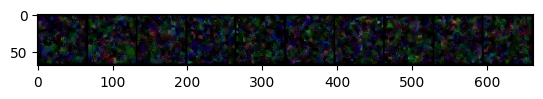

In [23]:
import torchvision

def sample_ddpm(model, num_samples):
    model.eval()
    with torch.no_grad():
        samples = torch.randn(num_samples, 3, 64, 64).cuda()
        for t in range(1000, 0, -1):
            predicted_noise = model(samples, torch.full((num_samples,), t/1000).cuda())
            samples = samples - predicted_noise / 1000  # 更新步驟
    return samples

generated_images = sample_ddpm(model, 10)  # 生成10張新圖片

# 轉換為PIL圖片並顯示
generated_images = generated_images.cpu().clamp(0, 1)
grid = torchvision.utils.make_grid(generated_images, nrow=10)
np_grid = grid.numpy().transpose((1, 2, 0))

import matplotlib.pyplot as plt
plt.imshow(np_grid)
plt.show()